## <h1><center> Laboratorio di WebScraping </h1>
<h1><center> Anno Accademico 2024-2025 </h1>
<h1><center>  Docente: Laura Ricci </h1>
<h1><center>  Lezione 20 </h1>
<h1><center>  Correzione Analisi Bitcoin DataSet</h1> 
<h1><center> 16 Aprile 2025 </h1>

## Struttura delle transaizioni Bitcoin

<center>
<img src="Figures/BitcoinTransactionChain.jpg" style="width:600px;height:400px;"/>


## Il DataSet delle transazioni

<center>
<img src="Figures/BitcoinTables.jpg" style="width:700px;height:600px;"/>

## Formato delle transazioni del DataSet

I principali elementi di una transazione **Bitcoin** sono i seguenti
<ul>
<li><b>hash</b>: identificatore della transazione </li>
<li><b>block_id</b>: identificatore del blocco che contiene la transazione </li>
<li><b>version</b></li>
<li><b>size</b></li>
<li><b>lock_time</b>: tempo prima del quale una transazione non può essere inserita in un blocco</li>
<li><b>vin_sz</b></li>
<li><b>vout_sz</b></li>
<li><b>inputs</b></li>
<li><b>outputs</b></li>
</ul>


## Formato delle transazioni nel DataSet

Alcuni campi sono stati eliminati:
<ul>
<li><b>version</b></li>
<li><b>size</b></li>
<li><b>lock_time</b></li>
<li><b>vin_sz</b></li>
<li><b>vout_sz</b></li>
</ul>

Modifiche

  * nel dataset, tutti i campi   <b>hash</b> sono stati sostituiti con un identificatore numerico <b>id</b>
    * questo ha permesso di ridurre la dimensione del dataset
  * le chiavi pubbliche e le firme sono astatte da identificatori: verifica che una firma corrisponda ad una chiave pubblica viene effettuata verificando l'uguaglianza degli identificatori

## Analisi richieste

* controllare se esistono blocchi o transazioni invalide nel dataset ed eventualmente rimuoverli/e
* calcolare le seguenti statistiche
    * distribuzione dei blocchi: numero di transazioni per ogni blocco, considerando l'intero periodo di tempo e per mese
    * distribuzione delle fee spese in ogni transazione nell'intero periodo
    * quanti UTXO esistono, al momento del mining dell'ultimo blocco del data set?
    * quale è l'UTXO a cui è associato il valore più alto?
    * trovare tutte le transazioni generate tra due date
* proporre almeno una analisi non compresa tra le precedenti

## Analisi di Bitcoin: il DataFrame delle transazioni

In [24]:
import pandas as pd; import matplotlib.pyplot as mat; import numpy as np
Transactions = pd.read_csv('Dataset/Transactions.csv',names=['tx_id', 'blk_id'])
Transactions

,tx_id,blk_id
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
216621,216622,100016
216622,216623,100016
216623,216624,100016
216624,216625,100016


* nei primi blocchi del **DataSet**, una sola transazione per blocco, 
   * si tratta di **Coinbase**, transazioni di ricompensa al miner che ha risolto la **Proof of Work**, probabilmente minate da **Nakamoto** stesso
* numero ultima transazione >> numero dell'ultimo blocco
   * diverse blocchi contengono molte transazioni  e gli ultimi blocchi includono più transazioni


## Analisi  di Bitcoin: il DataFrame degli Inputs

In [7]:
Inputs = pd.read_csv('DataSet/Inputs.csv', names=['in_id', 'tx_id', 'sig_id', 'output_id'])
Inputs

,in_id,tx_id,sig_id,output_id
0,1,1,0,-1
1,2,2,0,-1
2,3,3,0,-1
3,4,4,0,-1
4,5,5,0,-1
...,...,...,...,...
292422,292423,216622,95854,258874
292423,292424,216623,161394,247315
292424,292425,216624,173913,263227
292425,292426,216625,174188,263611


## Analisi  di Bitcoin: il DataFrame degli Inputs

* nelle prime righe 
    * l'**output_id** è sempre uguale  a **-1** questo conferma che si tratta di transazioni **Coinbase**: **puntatore nullo**
       * i bitcoin sono stati creati dal sistema, non provengono da una transazione precedente
    * gli **in_id** corrispondono ai **tx_id**: un solo input per ogni transazione, non significativo 
* nelle ultime righe: **in_id** >> **tx_id**
    * esistono transazioni con più di un input, molte transazioni con un solo input

## Analisi di Bitcoin: il DataFrame degli Outputs

In [9]:
Outputs = pd.read_csv('DataSet/Outputs.csv', names=['output_id', 'tx_id', 'pk_id', 'value'])
Outputs

,output_id,tx_id,pk_id,value
0,1,1,1,5000000000
1,2,2,2,5000000000
2,3,3,3,5000000000
3,4,4,4,5000000000
4,5,5,5,5000000000
...,...,...,...,...
264305,264306,216623,174700,1000000
264306,264307,216623,174701,299000000
264307,264308,216624,167815,1000000
264308,264309,216625,174695,1200000


## Analisi di Bitcoin: il DataFrame degli Outputs

* un solo output per ognuna delle prime transazioni
  * l'output corrisponde alla ricompensa data ai miners, inizialmente **5000000000 Satoshi = 50 BTC**, poi dimezzata ogni 4 anni
* nelle ultime righe il numero di **output_id** >> **tx_id**
  * esistono transazioni con output multipli
  * ad esempio la transazione <code> 216623 </code>  ha due output diversi  
* lo stesso nome **output_id** utilizzato come identificatore di un output e come riferimento in un campo input.
    * questo ci consentirà di effettuare il **merge** dei due dataset

## Controlli di validità delle transazioni: quali?

* input/output che fanno riferimento ad un tx_id non esistente
* input che fanno riferimento ad un output_id non esistente
* transazioni con pk_id/sign_id negativi
* output con “amount” negativo
* Transazioni in double spending
* Reward per il miner minore di **50 BTC**
* si cercano di spendere dei bitcoin appartenenti ad un indirizzo diverso dal proprio 
    * la chiave pubblica non è consistente con la firma
    * nel nostro caso, l'identificatore nell'output non corrisponde con quello nell'input

## Controlli di validità delle transazioni: corrispondenza chiave pubblica-firma

* le chiavi pubbliche e le firme sono astratte nel dataset con degli identificatori
* la corrispondenza tra chiave pubblica e signature è verificata in **Bitcoin** da uno script, nel nostro caso verificare la corrispondenza tra gli identificatori

In [10]:
#ricerca di record collegati tra input e output che non hanno i campi sig_id e pk_id uguali
print("ricerca corrispondenza errate tra pk_id e sig_id")
print()
InputOutput = pd.merge(Outputs, Inputs, on="output_id")
InputOutput

ricerca corrispondenza errate tra pk_id e sig_id



,output_id,tx_id_x,pk_id,value,in_id,tx_id_y,sig_id
0,10,10,10,5000000000,172,172,10
1,172,172,172,1000000000,219200,156787,172
2,173,172,10,4000000000,184,184,10
3,186,184,10,3000000000,186,186,10
4,188,186,186,100000000,228,228,186
...,...,...,...,...,...,...,...
192403,264258,216586,174659,13856000000,292383,216589,174659
192404,264262,216589,174663,13851000000,292387,216593,174663
192405,264268,216593,174668,13846000000,292394,216598,174668
192406,264275,216598,174674,13841000000,292403,216606,174674


* **merge**: **join** su una colonna comune
    * per default un **inner join**

* osservazione: poichè **tx_id** compare sia negli output che negli input, la merge introduce due nuovi identificatori **tx_id_x** e **yx_id_y**

## Controlli di validità delle transazioni: corrispondenza chiave pubblica-firma

In [11]:
Invalid_pk_sig = InputOutput.loc[InputOutput ['sig_id'] != InputOutput ['pk_id']]
print("Transazioni inconsistenti trovate =", len(Invalid_pk_sig.index))
print()
Invalid_pk_sig

Transazioni inconsistenti trovate = 2



,output_id,tx_id_x,pk_id,value,in_id,tx_id_y,sig_id
1678,16121,16081,16020,5000000000,194075,138278,139250
83064,137338,116208,113300,5000000000,157972,116411,-1


## Controlli di validità delle transazioni: corrispondenza chiave pubblica-firma

* per individuare le transazioni invalide, si crea un **row indexer**, un Serie di valori **Booleani**
    ```python 
    InputOutput.loc[InputOutput ['sig_id'] != InputOutput ['pk_id']]
    ```
    * la Serie è creata confrontando valori corrispondenti delle due serie, corrispondenti a due colonne del **DataFrame**
    ```python 
    InputOutput ['sig_id'] 
    InputOutput ['pk_id']
    ```   
* si passa il **row indexer** di valori booleani alla funzione **loc**
* la **Series** di valori booleani deve essere **allineata** con le righe del **DataFrame**    
* solo le righe in cui il valore corrispondente in **row indexer** è **True**, vengono selezionate 
* viene costruito un nuovo **DataFrame** con le righe selezionate

## Calcolo valore totale UTXO: individuazione output non spesi

* quale è il valore degli UXTO, al momento del **mining dell'ultimo blocco del data set**?
* **UTXO** valori non ancora spesi, stanno nell'output di una transazione, ma non sono riferiti dall'input di nessuna altra transazione


In [12]:
print("Calcolo valore totale in UXTO")
temp = (~Outputs['output_id'].isin(Inputs['output_id']))
print(type(temp))
temp

Calcolo valore totale in UXTO
<class 'pandas.core.series.Series'>


0         True
1         True
2         True
3         True
4         True
          ... 
264305    True
264306    True
264307    True
264308    True
264309    True
Name: output_id, Length: 264310, dtype: bool

## Calcolo valore totale UTXO: individuazione output non spesi

In [13]:
print("CALCOLO TOTALE UTXO")
UTXO = Outputs.loc[temp]
UTXO

CALCOLO TOTALE UTXO


,output_id,tx_id,pk_id,value
0,1,1,1,5000000000
1,2,2,2,5000000000
2,3,3,3,5000000000
3,4,4,4,5000000000
4,5,5,5,5000000000
...,...,...,...,...
264305,264306,216623,174700,1000000
264306,264307,216623,174701,299000000
264307,264308,216624,167815,1000000
264308,264309,216625,174695,1200000


## Calcolo dell'UTXO massimo

In [14]:
MaxUTXO = UTXO.value.max()
print("Massimo UTXO =", MaxUTXO )
SumUTXO = UTXO.value.sum()
print("Somma totale UTXO =", SumUTXO )
MaxUTXO_tx = UTXO.loc[UTXO['value'] == MaxUTXO] #cerco la riga  con valore massimo
MaxUTXO_tx = pd.merge(MaxUTXO_tx, Transactions, on=['tx_id'])
print(MaxUTXO_tx)

Massimo UTXO = 9000000000000
Somma totale UTXO = 500140414333354
   output_id   tx_id   pk_id          value  blk_id
0     170430  140479  138895  9000000000000   90532


## Analisi delle transazioni: calcolo delle fee

* considerare tutte le transazioni, a parte le **CoinBase**
* fees 
   <center>
    $ \sum (input) - \sum (output)$
    </center>   
  in cui input e output sono i valori in input e output della transazione
* somma dei valori in output di una transazione
  * <code> group_by </code> su <code> Output </code> in base a <code> tx_id </code>
* somma dei valori in input di una transazione
 * i valori spesi negli input non sono nel dataset **Input**, ma  in output precedenti
 * merge tra <code> Input </code> e <code> Output </code> su <code> output_id </code> 
 * a questo punto ho due **tx_id**, quello della transazione che ha generato l'output e quello della transazione che consuma al'output
    * per calcolare la fee, occorre considerare il <code> tx_id </code>  di  <code> Input </code>!
    * della transazione precedente interessa solo il valore in output non l'indice della transazione


## Analisi delle transazioni: calcolo somma output di ogni transazione

In [15]:
# elimino la colonna relativa allo script di firma, inutile
Out=Outputs.drop(['pk_id'], axis="columns")
OutTrans = Out.groupby('tx_id')['value'].sum().reset_index()  
OutTrans

,tx_id,value
0,1,5000000000
1,2,5000000000
2,3,5000000000
3,4,5000000000
4,5,5000000000
...,...,...
216621,216622,5000000000
216622,216623,300000000
216623,216624,1000000
216624,216625,1200000


* **drop** rimuove una colonna o una riga specifica
* **axis** specifica se si vuole eliminare una colonna o una riga
* la colonna viene eliminata nel nuovo dataset creato, non in quello originale

## Analisi delle transazioni: calcolo somma di  input di ogni transazione

* il problema della determinazione dei valori in input è più complesso, perchè
    * il valore di un input di una transazione si trova in un **Unspent Transaction Output (UTXO)** di una transazione precedente
    * serve collegare due diverse transazioni, quella che genera l'**output**, e quella che lo spende

In [25]:
Inp = Inputs.drop(['sig_id'] , axis='columns')
Out = Outputs.drop(['tx_id', 'pk_id'], axis='columns')
InpValues = pd.merge(Inp, Out, on='output_id')
InpValues

,in_id,tx_id,output_id,value
0,172,172,10,5000000000
1,184,184,173,4000000000
2,186,186,186,3000000000
3,188,188,189,2900000000
4,193,193,191,100000000
...,...,...,...,...
192403,292419,216618,264284,13836000000
192404,292423,216622,258874,5000000000
192405,292424,216623,247315,300000000
192406,292425,216624,263227,1000000


## Analisi delle transazioni: calcolo somma di  input di ogni transazione

* drop: elimina i campi non importanti per questa analisi
    * si elimina **tx_id** dagli **Output**, perchè non interessa l'indice della transazione che produce l'output
* merge: combina le righe con valore comune dell'attributo **output_id**
    * ogni input viene collegato all'output di una transazione precedente, di cui spende il valore
* analizziamo la riga <code> 192403 </code>
```
292419 216618 264284 13836000000
```
    * la transazione <code> 216618 </code>ha un input di indice <code> 292419</code>  che "consuma un output precedente" di indice <code> 264284</code>  di valore <code> 13836000000</code> . 
    * non interessa l'indice della transazione precedente, solo il valore in output che viene speso nell'input della transazione <code> 216618</code> 


## Analisi delle fee: e le coinbase?

* la procedura precedente non considera le **Coinbase**
* cosa è una **Coinbase**?
    * la prima transazione in ogni blocco della blockchain
    * utilizzata per inviare la ricompensa al miner che ha minato quel blocco
* il formato è lo stesso delle altre transazioni eccetto che
    * ha esattamente un input
    * quell'input non punta ad un **UXTO** precedente e non contiene un dato significativo
    * può contenere messaggia arbitrari
        * il messaggio di **Nakamoto** nella prima Coinbase: *“The Times 03/Jan/2009 Chancellor on brink of second bailout for banks"*
    * non ha fee
* gli output della transazione
    * possono essere in numero arbitrario
    * uno o più indirizzi del miner
    * la somma dei valori in output non può superare la somma della ricompensa data al miner sommata con le fee di tutte le transazioni di quel blocco.


## Analisi delle fee: e le coinbase?

* nel nostro DataSet
    * le **Coinbase** sono  transazioni che contengono un solo input
    * quell'input ha valore **-1**
    * il <code> sig_id </code> vale **0**
* le coinbase non sono incluse nel risultato del <code> merge </code>, perchè non c'è corrispondenza tra -1 con un precedente <code> output_id </code>
* verifichiamolo!

In [17]:
InpValues.loc[InpValues["output_id"]==-1]

,in_id,tx_id,output_id,value


## Analisi delle transazioni: calcolo valore in input di ogni transazione

In [26]:
InpValues.rename(columns={'in_id':'in_id', 'tx_id':'tx_id' , 'output_id':'utxo_id' , 'value':'value_to_be_spent'}, inplace=True)
InpTrans = InpValues.groupby('tx_id')['value_to_be_spent'].sum().reset_index()
InpTrans

,tx_id,value_to_be_spent
0,172,5000000000
1,184,4000000000
2,186,3000000000
3,188,2900000000
4,193,100000000
...,...,...
116602,216618,13836000000
116603,216622,5000000000
116604,216623,300000000
116605,216624,1000000


## Analisi delle transazioni: calcolo delle fee

In [21]:
Tx = pd.merge(InpTrans, OutTrans, on='tx_id') 
Tx['fees'] = Tx['value_to_be_spent'] - Tx['value'] 
TxGreter0 = Tx.loc[Tx['fees'] > 0].sort_values('fees')
TxLessEq0 = Tx.loc[Tx['fees'] == 0]
TxLessLess0 = Tx.loc[Tx['fees'] < 0].sort_values('fees')
TxGreter0 , TxLessEq0, TxLessLess0

(        tx_id  value_to_be_spent         value         fees
 36423  117594       200000000010  200000000000           10
 33797  112674         5001999810    5001999800           10
 33874  112792         5001999800    5001999790           10
 32656  110246         5001999860    5001999850           10
 33270  111604         5001999840    5001999830           10
 ...       ...                ...           ...          ...
 5090    60913         5000000000    4665000000    335000000
 28386  101662       900432000000  900000000000    432000000
 27990  100849        20003971000   15004000000   4999971000
 22463   92976         5000000000         29000   4999971000
 30230  105281         5000000000   -5000000000  10000000000
 
 [1301 rows x 4 columns],
          tx_id  value_to_be_spent        value  fees
 0          172         5000000000   5000000000     0
 1          184         4000000000   4000000000     0
 2          186         3000000000   3000000000     0
 3          188         

* esiste una transazione con fee negativa: un errore nel Dataset

## Analisi delle transazioni: calcolo delle fee

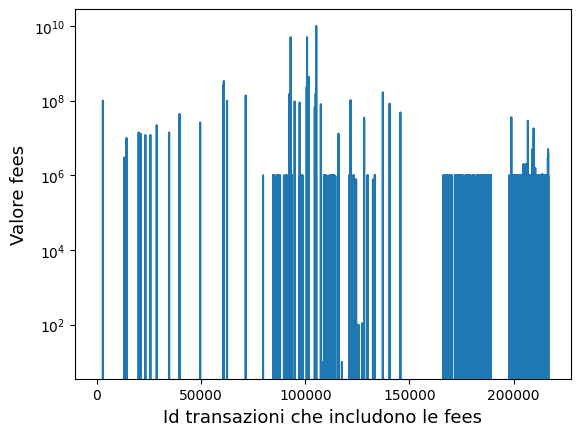

In [22]:
#plotting della distribuzione delle fees con valore maggiore di 0
Tx_Correct=Tx.loc[Tx['fees']>=0]
X = list(Tx_Correct['tx_id'])
mat.plot(X,Tx_Correct['fees'])
mat.xlabel('Id transazioni che includono le fees', fontsize=13)
mat.ylabel('Valore fees', fontsize=13)
mat.yscale('log')
mat.show()
